In [16]:
# Using dynamax for model inference

In [121]:
from functools import partial
import matplotlib as mpl
import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap
from jax.nn import one_hot

from dynamax.hidden_markov_model import CategoricalHMM
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [195]:
# setting

cluster_color = {
  -1: '#dbdbdb',
  0: '#BB0A21',
  1: '#FF680A',
  2: '#ffa047',
  3: '#0B305E',
  #6: '#0E6593'
  #5: '#0BACC1'
  4: '#6B0F67',
  5: '#a24d91',
  #6: '#028E51'
  #7: '#07A855'
}
cluster_label= {
  -1: 'N/A',
  0: 'pred. feed',
  1: 'pred. bite' ,
  2: 'pred. search',
  3: 'dwelling' ,
  4: 'exploration',
  5: 'roaming',
  #6: transi low velo
  #7: transi high velo
}    

In [356]:



def plot_map_sequence(most_likely_states, states):
    plt.imshow(states[None, :], extent=(0, num_timesteps, -0.05, 1.05), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.plot(most_likely_states)
    plt.xlabel("time")
    plt.ylabel("MAP state")
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 1])
    plt.title("Viterbi estimate")
    
def print_params(params):
    jnp.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    print("initial probs:")
    print(params.initial.probs)
    print("transition matrix:")
    print(params.transitions.transition_matrix)
    print("emission probs:")
    print(params.emissions.probs[:, 0, :]) # since num_emissions = 1
    
def plot_sequence(states, emissions):
    plt.imshow(one_hot(emissions[:, 0], 6).T, 
               aspect="auto", interpolation="none", cmap="Greys")
    plt.imshow(states[None, :], extent=(0, num_timesteps, num_classes-.5, -.5), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.xlabel("time")
    plt.ylabel("emission")
    plt.yticks(jnp.arange(6), jnp.arange(6) + 1)    # b/c python is zero indexed!
    plt.title("sampled sequence (white=fair, gray=loaded)")
    
    
    # plotting helper dictionaries
def ethogram_only_plotter(y, onoff, cluster_color, figsize=(20,2), fps=30,xtick_spread=100):
    timeinsec = np.array(range(len(y)))/fps
    
    fig, ax = plt.subplots(1, figsize=figsize,constrained_layout=True)
    
    for c in np.unique(y).astype(int):
        axs[0].broken_barh(onoff[c],(0,1),facecolors = cluster_color[c])
    axs[0].set_xticks(range(len(timeinsec))[::xtick_spread*fps])
    axs[0].set_xticklabels(timeinsec[::xtick_spread*fps].astype(int))
    axs[0].set_title(f'Cluster preditcion (smoothed {smooth/fps} sec).')

    plt.legend(handles=[Patch(facecolor=cluster_color[i]) for i in np.unique(y).astype(int)],
          labels=[clu_group_label[k] for k in cluster_label if k in np.unique(y)],
          ncol=3, loc='upper left',
          bbox_to_anchor=(0, -0.5))
    fig.suptitle(f'Ethogram of {fn}',fontsize=16)
    return fig

def extract_ethograms(df, nsamples, downsample=1):
    tmp = []
    count = []
    for col in df.columns[nsamples]:
        etho = df[col]['ethogram']
        etho = [e for e in etho if e!=-1]
        tmp.append(etho[::downsample])
        count.append(len(etho))
    # crop to min length
    lens =[len(a) for a in tmp]
    min_len = int(np.mean(lens))
    #tmp = [a[:min_len] for a in tmp]
    tmp = [np.pad(a, pad_width=(0, int(np.max([min_len-len(a),0]))),mode='constant', constant_values=-1)[:min_len] for a in tmp]
    return np.array(tmp), count


def plot_ethograms(ax, data, cluster_color, cluster_label, cbar = False, fps=30):
    colors = [c for c in cluster_color.values()]
    cmap_cluster = mpl.colors.ListedColormap(colors, name='cluster', N=None)
    #
    timeinsec = np.arange(data.shape[1]/fps)
    xtick_spread = 30
    # set limits .5 outside true range
    mat = ax.imshow(data, cmap=cmap_cluster, vmin=-1, 
                      vmax=5, aspect='auto', extent = (min(timeinsec), max(timeinsec),0,data.shape[0]), origin='lower', interpolation='nearest')
    #print(range(len(timeinsec))[::xtick_spread*fps])
    ax.set_xticks(np.arange(min(timeinsec), np.max(timeinsec), xtick_spread))
    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.25)
        # tell the colorbar to tick at integers
        n_clusters = len(cluster_label)
        offset = (n_clusters-1)/(n_clusters)
        tick_locs = np.arange(-0.6,n_clusters-2,offset)#*0.6#*(n_clusters-2)/(n_clusters-1)
        cbar = plt.colorbar(mat,cax=cax, ticks=tick_locs)#, norm=norm)#, shrink=0.5)
        cbar.ax.set_yticklabels([c for c in cluster_label.values()])
    return mat


### I/O - read data and visualize

In [113]:
# example sequence
dset1 = '~/scratch/PpaPred_eren_35727184/Exp1_WT_larvae_batch.json'
dset2 = '~/scratch/PpaPred_eren_35727184/Exp1_WT_OP50_batch.json'
df_op50 = pd.read_json(dset2)
df_larvae = pd.read_json(dset1)

In [357]:
etho_op50, counts = extract_ethograms(df_op50, nsamples=np.arange(len(df_op50.columns)), downsample=15)
etho_larvae, counts = extract_ethograms(df_larvae, nsamples=np.arange(len(df_larvae.columns)), downsample=15)

Text(0.5, 1.0, 'On bacteria')

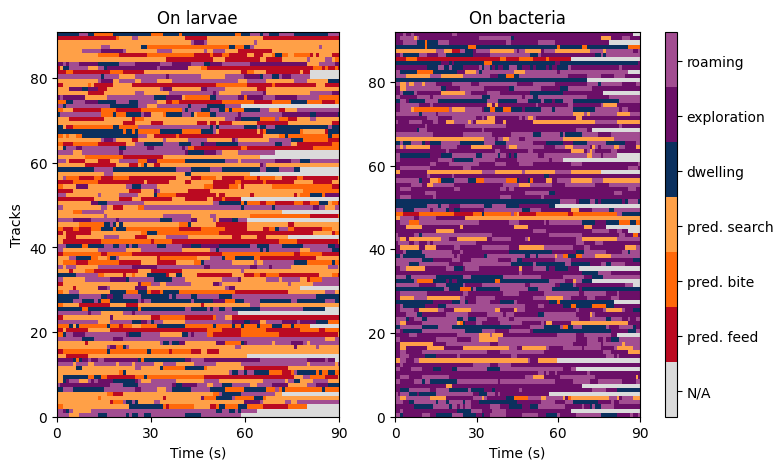

In [360]:
f, ax = plt.subplots(1,2, figsize=(8,5))
plot_ethograms(ax[0], etho_larvae, cluster_color,cluster_label, fps=2)
plot_ethograms(ax[1], etho_op50, cluster_color,cluster_label, cbar = True, fps=2)
ax[0].set_ylabel('Tracks')
plt.setp(ax, xlim=(0,90), xlabel= 'Time (s)')
ax[0].set_title('On larvae')
ax[1].set_title('On bacteria')
#plt.savefig('Ethograms_predicted.pdf')

## Set up the Categorical HMM

In [361]:
initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.995, 0.005], 
                               [0.010, 0.990]])


print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: (2, 2)
B.shape: (2, 6)


In [382]:
# let's set the emission probs equal the state probs but we divide it a-priori by the two inferred states
total = len(etho_larvae.flatten())

emission_probs = jnp.array([[np.sum(etho_larvae==0)/total,  np.sum(etho_larvae==1)/total,  np.sum(etho_larvae==2)/total,  0,0,0],    # predatory
                            [0,0,0,np.sum(etho_larvae==3)/total,np.sum(etho_larvae==4)/total,np.sum(etho_larvae==5)/total]])  # docile
emission_probs /= np.sum(emission_probs,axis=1)[:,np.newaxis]

In [383]:
print(emission_probs)

[[0.287 0.192 0.521 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.303 0.127 0.570]]


In [384]:
np.sum(etho_larvae==0)/total

0.12843696388000186

In [385]:
num_states = 2      # two types of hidden states - predatory or docile
num_emissions = 1   # only one behavior is output at a time
num_classes = 6     # we have six behavioral states

# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(initial_probs=initial_probs,
                           transition_matrix=transition_matrix,
                           emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes))

In [386]:
num_timesteps = 3000
true_states, emissions = hmm.sample(params, jr.PRNGKey(42), num_timesteps)

print(f"true_states.shape: {true_states.shape}")
print(f"emissions.shape: {emissions.shape}")
print("")
print("First few states:    ", true_states[:5])
print("First few emissions: ", emissions[:5, 0])

true_states.shape: (3000,)
emissions.shape: (3000, 1)

First few states:     [1 1 1 1 1]
First few emissions:  [5 5 3 5 3]


In [389]:
# To sample multiple sequences, just use vmap
num_batches = 50

batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(12), num_batches))

print(f"batch_states.shape: {batch_states.shape}")
print(f"batch_emissions.shape: {batch_emissions.shape}")

batch_states.shape: (50, 3000)
batch_emissions.shape: (50, 3000, 1)


Text(0.5, 1.0, 'Model')

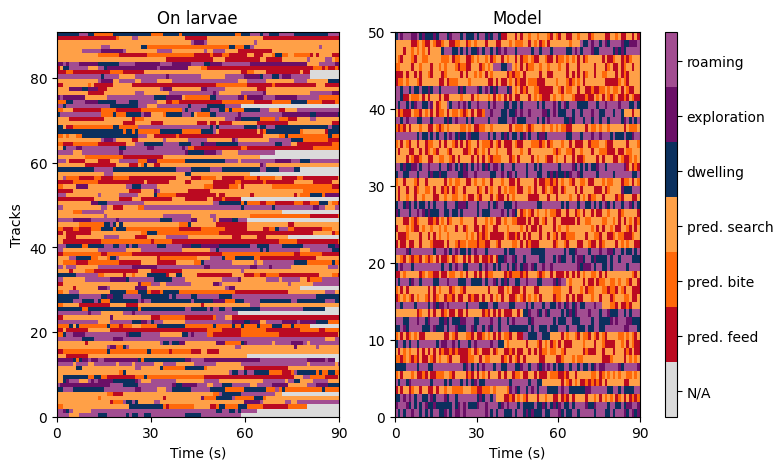

In [390]:
f, ax = plt.subplots(1,2, figsize=(8,5))
plot_ethograms(ax[0], etho_larvae, cluster_color,cluster_label, fps=2)
plot_ethograms(ax[1], batch_emissions, cluster_color,cluster_label, cbar = True, fps=1)
ax[0].set_ylabel('Tracks')
plt.setp(ax, xlim=(0,90), xlabel= 'Time (s)')
ax[0].set_title('On larvae')
ax[1].set_title('Model')
#plt.savefig('Ethograms_categorical.pdf')

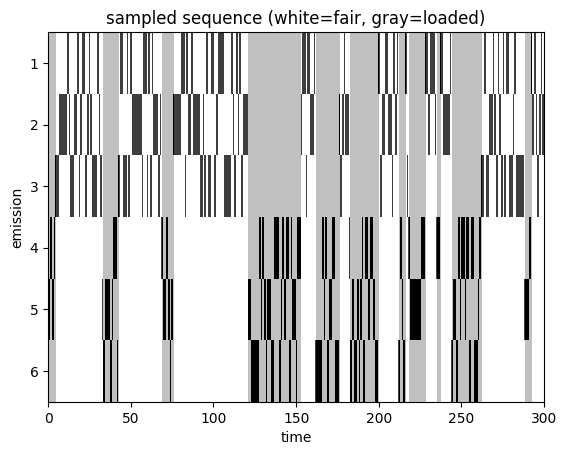

In [345]:
plot_sequence(batch_states[0], batch_emissions[0])

In [391]:
key = jr.PRNGKey(0)
em_params, em_param_props = hmm.initialize(key)
em_params, log_probs = hmm.fit_em(em_params, 
                                  em_param_props, 
                                  etho_larvae, 
                                  num_iters=400)

AssertionError: array does not match expected shape!

In [15]:
print_params(em_params)

initial probs:
[0.044 0.956]
transition matrix:
[[0.530 0.470]
 [0.716 0.284]]
emission probs:
[[0.260 0.090 0.035 0.171 0.208 0.236]
 [0.008 0.212 0.303 0.100 0.036 0.341]]


In [4]:
def collate_ethograms(df, nsamples):
    tmp = []
    count = []
    for col in df.columns[nsamples]:
        etho = df[col]['ethogram']
        etho = [e for e in etho if e!=-1]
        tmp += etho
        count.append(len(etho))
    return np.array(tmp).reshape((-1,1)), count

# Building HMM for predation state prediction

In [ ]:
# split our data into training and validation sets (50/50 split)-- use half of the columns we have
# get collated ethogram. hmmlearn can deal with this during learning if the lengths of the subsets are also added.
n = np.arange(len(df.columns[:]))
np.random.shuffle(n)
X_train, count_validate = collate_ethograms(df, nsamples = n[:len(n)//2])
X_validate, count_validate = collate_ethograms(df, nsamples = n[len(n)//2:])
# REMOVE NANS 
X_train[X_train==-1.0] = 13
X_validate[X_validate==-1.0] = 13

best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.CategoricalHMM(
        n_components=2, random_state=idx,
        init_params='se')  # don't init transition, set it below
    # we need to initialize with random transition matrix probabilities
    # because the default is an even likelihood transition
    # we know transitions are rare (otherwise the casino would get caught!)
    # so let's have an Dirichlet random prior with an alpha value of
    # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
    # of the time
    model.transmat_ = np.array((0.5, 0.5),
                                (0.5,0.5))
    model.fit(X_train)
    score = model.score(X_validate)
    print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'\nBest score:      {best_score}')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = best_model.predict(X_train)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(null_model, label='null model')
ax.plot(states + 1.5, label='estimated')
ax.plot(X_train)
#ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time ')
ax.set_xlabel('State')
ax.legend()
fig.show()

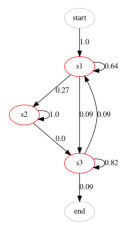

In [2]:
from pomegranate import HiddenMarkovModel, State, DiscreteDistribution
from matplotlib import pyplot as plt

def build_model():

    d1 = DiscreteDistribution({'A' : 0.50, 'B' : 0.50})
    d2 = DiscreteDistribution({'A' : 0.10, 'B' : 0.90})
    d3 = DiscreteDistribution({'A' : 0.90, 'B' : 0.10})

    s1 = State(d1, name="predatory")
    s2 = State(d2, name="docile")
    s3 = State(d3, name="predatory feeding")

    model = HiddenMarkovModel(name='my model')
    model.add_states(s1, s2, s3)
    model.add_transition(model.start, s1, 1.0)
    model.add_transition(s1, s1, 0.7)
    model.add_transition(s1, s2, 0.3) # s1->s2
    model.add_transition(s2, s2, 0.8)
    
    model.add_transition(s2, s3, 0.0) # no transition from s2 to s3
    model.add_transition(s1, s3, 0.1) # indirect from s1 to s3
    model.add_transition(s3, s1, 0.1) # indirect from s3 to s1
    
    model.add_transition(s3, s3, 0.9)
    model.add_transition(s3, model.end, 0.1)
    model.start.name = 'start'
    model.end.name = 'end'
    model.bake()

    return model

model = build_model()
fig, ax = plt.subplots(1)
model.plot(ax=ax, precision=2)
#fig.savefig('model.png')

In [1]:
def build_model():

    d1 = DiscreteDistribution({'A' : 0.50, 'B' : 0.50})
    d2 = DiscreteDistribution({'A' : 0.10, 'B' : 0.90})
    d3 = DiscreteDistribution({'A' : 0.90, 'B' : 0.10})

    s1 = State(d1, name="s1")
    s2 = State(d2, name="s2")
    s3 = State(d3, name="s3")

    model = HiddenMarkovModel(name='my model')
    model.add_states(s1, s2, s3)
    model.add_transition(model.start, s1, 1.0)
    model.add_transition(s1, s1, 0.7)
    model.add_transition(s1, s2, 0.3) # s1->s2
    model.add_transition(s2, s2, 0.8)
    
    model.add_transition(s2, s3, 0.0) # no transition from s2 to s3
    model.add_transition(s1, s3, 0.1) # indirect from s1 to s3
    model.add_transition(s3, s1, 0.1) # indirect from s3 to s1
    
    model.add_transition(s3, s3, 0.9)
    model.add_transition(s3, model.end, 0.1)
    model.start.name = 'start'
    model.end.name = 'end'
    model.bake()

    return model

model = build_model()
fig, ax = plt.subplots(1)
model.plot(ax=ax, precision=2)
#fig.savefig('model.png')

NameError: name 'DiscreteDistribution' is not defined

In [3]:
from hmmlearn import hmm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import check_random_state

from hmmlearn.hmm import CategoricalHMM

rs = check_random_state(276)

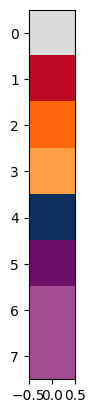

In [46]:
plt.imshow(np.arange(8)[:,np.newaxis], cmap =cmap_cluster)